# Metabolism at a glance - Exercises

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import numpy

Hint: Use page 76 and forward in Villadsen et al
An average biomass elemental composition of CH1.8O0.5N0.2 may be used

## Batch data analysis

A yeast strain was cultivated in batch culture under anaerobic conditions and samples were analyzed for the dry weight, glucose, ethanol and glycerol concentrations.

Let's read the file using pandas.

### batch_data = pd.read_csv("data/batch-data-analysis-data.csv")
batch_data

### a)

Plot the data, find the region with the exponential growth and find $μ_{max}$

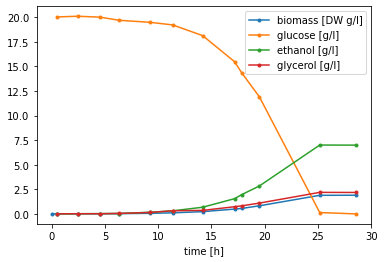

In [4]:
batch_data.plot(x='time [h]', style='.-');

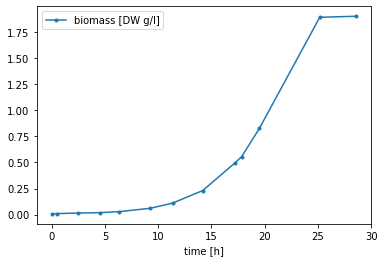

In [12]:
# Growth = biomass. We take a closer look

batch_data.plot(x='time [h]', y ='biomass [DW g/l]', style='.-');


In [ ]:
# Solution: Can plot the y-axis as log

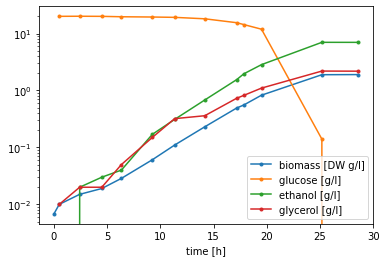

In [13]:
batch_data.plot(x='time [h]', logy=True, style='.-');

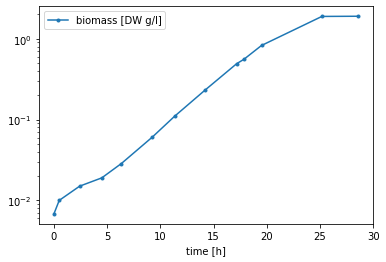

In [14]:
fig = batch_data.plot(x='time [h]', y='biomass [DW g/l]', logy=True, style='.-');

In [17]:
# use scipy to fit an expontial function to the data
from scipy.optimize import curve_fit

func = lambda t, a, mu_max: a*numpy.exp(mu_max*t)

# Through visual inspection, rows 5-11 (4-10 using Python indexing) 
# should provide a suitable range for curve fitting.

exp_time_points = batch_data.loc[4:10, 'time [h]']
exp_phase_biomass = batch_data.loc[4:10, 'biomass [DW g/l]']

popt, pcov = curve_fit(func, exp_time_points, exp_phase_biomass)

In [20]:
popt

array([0.00760486, 0.24078499])

In [21]:
# So a = 0.0076 and mu_max = 0.24

intercept, mu_max = popt

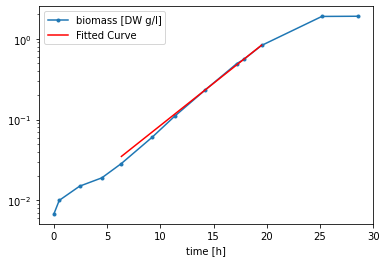

In [22]:
# Let's inspect the fitted curve using plots.

fig, ax = plt.subplots()
batch_data.plot(x='time [h]', y='biomass [DW g/l]', logy=True, ax=ax, style='.-');
ax.plot(exp_time_points, func(exp_time_points, *popt), 'r-', label="Fitted Curve")
ax.legend();

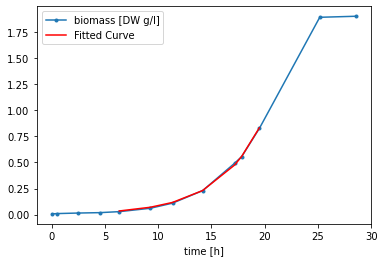

In [23]:
fig, ax = plt.subplots()
batch_data.plot(x='time [h]', y='biomass [DW g/l]', ax=ax, style='.-');
ax.plot(exp_time_points, func(exp_time_points, *popt), 'r-', label="Fitted Curve")
ax.legend();

### b) 

During exponential growth the yield coefficients should be constant. Prove it by plotting. Calculate the yield coefficients for biomass, ethanol and glycerol on glucose (Ysx, Yse, and Ysg) in g/g and in Cmol/Cmol.
Assume the generalized composition of the biomass: $CH_{1.8}O_{0.5}N_{0.2}$.

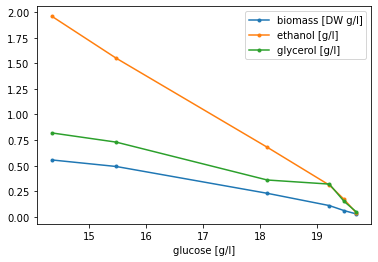

In [26]:
batch_data.iloc[4:10, 1:].plot(x='glucose [g/l]', style='.-');

In [27]:
# The plots of concentrations of biomass, ethanol and glycerol against glucose are linear in the exponential 
# growth phase, proving that the yield coefficients are constant. Let's fit linear models to obtain the 
# slopes/yield coefficients (this time we're going to use scikit-learn)


from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score


In [28]:
df = batch_data[4:10] # again, let's use only the data points of the exponential growth phase

biomass [DW g/l] -0.09935749361199336 * y 2.0063513326697957; r2 = 0.9901882229397242; MSE = 0.0004201557854267896
ethanol [g/l] -0.34841362076291327 * y 6.957147291815009; r2 = 0.9976523894280985; MSE = 0.0012269199751399817
glycerol [g/l] -0.13273278633500124 * y 2.756361309924547; r2 = 0.9495606098019909; MSE = 0.0040195990705296815


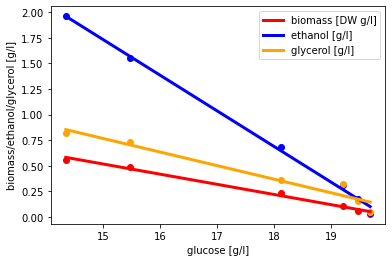

In [29]:
yields = dict() # store the fitted yield coefficients
colors = ('red', 'blue', 'orange') # colors for the plots
for i, var in enumerate(['biomass [DW g/l]', 'ethanol [g/l]', 'glycerol [g/l]']):
    reg = linear_model.LinearRegression()
    reg.fit(df[['glucose [g/l]']], df[var])
    predicted = reg.predict(df[['glucose [g/l]']])
    slope = reg.coef_[0]
    intercept = reg.intercept_
    yields[var.split(" ")[0]] = -1 * slope # store the result
    r2 = r2_score(df[var], predicted)
    mse = mean_squared_error(df[var], predicted)
    print(var, f'{slope} * y {intercept}; r2 = {r2}; MSE = {mse}')
    # plot the fitted lines
    plt.scatter(df[['glucose [g/l]']], df[var],  color=colors[i])
    plt.plot(df[['glucose [g/l]']], predicted, color=colors[i], linewidth=3, label=var)
    plt.legend()
    plt.xlabel('glucose [g/l]')
    plt.ylabel('biomass/ethanol/glycerol [g/l]')

In [30]:
yields

{'biomass': 0.09935749361199336,
 'ethanol': 0.34841362076291327,
 'glycerol': 0.13273278633500124}

In [32]:
# Converting into Cmol:
yields_cmol = dict()
yields_cmol['biomass'] = yields['biomass'] * (30/24.6) # (30 gGLC/CmolGLC) / (24.6 g gDW/CmolDW)
yields_cmol['ethanol'] = yields['ethanol'] * (30/23) # (30 gGLC/CmolGLC) / (23 gETH/CmolETH)
yields_cmol['glycerol'] = yields['glycerol'] * (30/30.67) # (30 gGLC/CmolGLC) / (30.67 gGLYC/CmolGLYC)

yields_cmol

{'biomass': 0.12116767513657727,
 'ethanol': 0.45445254882119124,
 'glycerol': 0.12983317867786232}

### c)

Make a C balance and calculate the yield of CO2 on glucose ($Y_{sc}$).

In [35]:
# C balance:
# 1 = Ysx + Yse + Ysg + Ysco2
# Ysco2 = 1 - Ysx - Yse - Ysg
Y_sco2_cmol = 1 - yields_cmol['biomass'] - yields_cmol['ethanol'] - yields_cmol['glycerol']

Y_sco2_cmol


0.2945465973643692

### d)

Using the calculated μmax and yield coefficients, calculate the specific consumption rate for glucose ($r_s$) and specific production rates for ethanol, glycerol and CO2 ($r_e$, $r_g$, and $r_c$). Use units of C-mmol/g DW·h.

In [41]:
# rs = Yxs * mu_max = (1/Ysx) * mu_max
rs = yields['biomass']**-1 * mu_max # 2.42

# re = Yse * rs   osv.
re = yields_cmol['ethanol'] * rs # 1.10
rg = yields_cmol['glycerol'] * rs # 0.31
rco2 = Y_sco2_cmol * rs # 0.71

rs, re, rg, rco2

# Omregning til mmol


(2.423420565516901,
 1.1013296528648484,
 0.31464039529436194,
 0.7138102815558386)